In [ ]:
import os
print(os.listdir("../data/carvana-image-masking-challenge/"))

DATASET_DIR = '../data/carvana-image-masking-challenge/'
WORKING_DIR = '../data/carvana-image-masking-challenge/'

['29bb3ece3180_11.jpg', 'expert_outputs', 'metadata.csv', 'sample_submission.csv', 'saved_images', 'test', 'train', 'train_masks', 'val', 'val_masks']


In [2]:
# print(
#     len(os.listdir(WORKING_DIR + 'train')),
#     len(os.listdir(WORKING_DIR + 'train_masks'))
# )

# train_dir = WORKING_DIR + 'train/'
# val_dir = WORKING_DIR + 'val/'
# os.mkdir(val_dir)

# for file in sorted(os.listdir(train_dir))[4600:]:
#   shutil.move(train_dir + file, val_dir)
  
# masks_dir = WORKING_DIR + 'train_masks/'
# val_masks_dir = WORKING_DIR + 'val_masks/'
# os.mkdir(val_masks_dir)

# for file in sorted(os.listdir(masks_dir))[4600:]:
#   shutil.move(masks_dir + file, val_masks_dir)

# os.mkdir(WORKING_DIR + 'saved_images')
# os.mkdir(WORKING_DIR + 'expert_outputs')

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.jpg', '_mask.gif'))
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask

In [4]:
import torch
import torch.nn.functional as F

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.

    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.

    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.

    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        # print(true.squeeze(1).dtype)
        true = true.long()
        true_1_hot = torch.eye(num_classes + 1, device = 'cuda')[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return dice_loss

# def helper_dice(true,logits,temperature):
#     batch_size = true.shape[0]
#     dice = 0
#     for i in range(batch_size):
#         dice += torch.abs(dice_loss(torch.unsqueeze(true[i,:,:,:],0),torch.unsqueeze(logits[i,:,:,:],0)) - temperature)
#     return dice/batch_size

def helper_dice_similarity(map1, map2):
    """
    Computes a similarity loss between two segmentation maps.

    Args:
        map1: first segmentation map of shape [B, C, H, W].
        map2: second segmentation map of shape [B, C, H, W].

    Returns:
        similarity_loss: scalar similarity loss.
    """
    batch_size = map1.shape[0]
    loss = 0
    for i in range(batch_size):
        loss += dice_loss(
            torch.unsqueeze(map1[i], 0),
            torch.unsqueeze(map2[i], 0)
        )
    # Higher similarity reduces the loss.
    return 1 - loss / batch_size

In [5]:
import torch
import torch.nn as nn

def IntersectionOverUnion(seg1, seg2):
    
    intersection = torch.min(seg1, seg2)
    union = torch.max(seg1, seg2)


    IoU = intersection.sum() / union.sum()
    return IoU


def MutuallyExclusiveLoss(partial_segmentation_maps):
    loss = 0
    N = len(partial_segmentation_maps) * len(partial_segmentation_maps[0])
    for i in range(len(partial_segmentation_maps)):
        for j in range(len(partial_segmentation_maps[0])):
            for k in range(len(partial_segmentation_maps)):
                for l in range(len(partial_segmentation_maps[0])):
                    if (i, j) != (k, l):
                        loss += helper_dice_similarity(partial_segmentation_maps[i][j], partial_segmentation_maps[k][l])

    loss = loss / (2 * N * (N - 1))
    return loss

def CombinedLoss(pred, psm, target):
    BCE = nn.BCEWithLogitsLoss()
    return BCE(pred, target) + MutuallyExclusiveLoss(psm)
    

In [6]:
import torch.nn as nn

class Expert(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Expert, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.encoder(x)
        d1 = self.decoder(e1)
        return e1, d1

class Expertlayer(nn.Module):
  def __init__(self, expert_num, in_channels, out_channels):
    super(Expertlayer, self).__init__()
    self.expert_num = expert_num
    self.experts = nn.ModuleList([Expert(in_channels, out_channels) for _ in range(self.expert_num)])
  def forward(self,x_list):
    assert len(x_list) == self.expert_num
    e_list =[]
    d_list = []
    for loop in range(self.expert_num):
      encoder,decoder = self.experts[loop](x_list[loop])
      e_list.append(encoder)
      d_list.append(decoder)

    return e_list,d_list

class DecoderLayer(nn.Module):
  def __init__(self, out_channels):
    super(DecoderLayer, self).__init__()
    self.out_channels =out_channels
    self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, self.out_channels, 3, padding=1), nn.ReLU()
        )
  def forward(self,x):
      return self.decoder(x)


class Router(nn.Module):
  def __init__(self, input_expert_num,input_out_channels, output_expert_num):
    super(Router, self).__init__()
    self.input_expert_num = input_expert_num
    self.decoder = nn.ModuleList([DecoderLayer(input_out_channels) for _ in range(output_expert_num)])

    self.router_layer = nn.Sequential(
        nn.Conv2d(input_out_channels, 64, 3, padding=1), nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * 224 * 224, output_expert_num), #This part is still hardcoded based on the image size
        nn.Sigmoid()
        )


  def forward(self, x_list):
    decoder_outputs = []
    for loop in range(len(self.decoder)):
      decoder_outputs.append(self.decoder[loop](x_list[loop]))

    router_input = torch.stack(decoder_outputs).sum(dim=0)
    router_output = self.router_layer(router_input)
    weights = router_output.view(router_output.shape[0], self.input_expert_num, 1, 1) # Added batch dimension to weights
    stacked_outputs = torch.stack(decoder_outputs)
    weighted_outputs = weights * stacked_outputs
    summed_outputs = weighted_outputs.sum(dim=0)
    return summed_outputs

class MoE(nn.Module):
  def __init__(self, input_expert_num, input_out_channels, output_expert_num):
    super(MoE, self).__init__()
    self.input_expert_num = input_expert_num
    self.expert_layer1 = Expertlayer(input_expert_num, input_out_channels, input_out_channels)
    self.router1 = Router(input_expert_num, input_out_channels, output_expert_num)
    self.expert_layer2 = Expertlayer(input_expert_num, input_out_channels, input_out_channels)

  def forward(self, x):
    x_list = [x for i in range(self.input_expert_num)]
    e1,d1 = self.expert_layer1(x_list)
    r1 = self.router1(e1)
    r1_list = [r1 for i in range(self.input_expert_num)]
    e2,d2 = self.expert_layer2(r1_list)
    decoder_outputs = [d1, d2]
    d1, d2 = torch.stack(d1).sum(dim=0), torch.stack(d2).sum(dim=0) #This part is changed
    all_seg_maps = torch.cat((d1, d2), dim=1)
    final_segmentation_map = all_seg_maps.sum(dim=1)
    final_segmentation_map = final_segmentation_map.unsqueeze(1) #making sure the dimensions are consistent
    return final_segmentation_map, decoder_outputs

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

def get_loaders(
    train_dir, train_maskdir, val_dir, val_maskdir, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True,):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds, _ = model(x)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f'Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}'
    )
    print(f'Dice score: {dice_score/len(loader)}')
    model.train()

def save_predictions_as_imgs(
        loader, model, folder=WORKING_DIR, device='cuda'
):
    saved_images_folder = folder +'saved_images'
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds, expert_outputs = model(x)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f'{saved_images_folder}/pred_{idx}.png'
        )
        torchvision.utils.save_image(
            y.unsqueeze(1), f'{saved_images_folder}/truth_{idx}.png'
        )
        for layer in range(len(expert_outputs)):
            for expert in range(len(expert_outputs[0])):
                torchvision.utils.save_image(expert_outputs[layer][expert], f'{folder}/expert_outputs/{idx}_{layer}_{expert}.png')

In [8]:
import matplotlib.pyplot as plt

def plot_gradient_flow(model):
    ave_grads = []
    layers = []
    for name, param in model.named_parameters():
        if param.grad is not None and param.requires_grad:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().item())
    
    plt.figure(figsize=(10, 5))
    plt.bar(layers, ave_grads, color="b", alpha=0.6)
    plt.hlines(0, 0, len(ave_grads), color="k", linestyle="dashed", linewidth=0.5)
    plt.xticks(rotation=90)
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient Magnitude")
    plt.title("Gradient Flow")
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1
NUM_EPOCHS = 5
NUM_WORKERS = 0
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = '../data/carvana-image-masking-challenge/train/'
TRAIN_MASK_DIR = '../data/carvana-image-masking-challenge/train_masks/'
VAL_IMG_DIR = '../data/carvana-image-masking-challenge/val/'
VAL_MASK_DIR = '../data/carvana-image-masking-challenge/val_masks/'
print(DEVICE)

cuda


In [16]:
def train_fn(loader, model, optimizer, loss_fn, scaler):

    loop = tqdm(loader)


    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)

        targets = targets.float().unsqueeze(1).to(device=DEVICE)


        # forward

        with torch.amp.autocast('cuda'):

            predictions, expert_output = model(data)

            loss = loss_fn(predictions, expert_output, targets)


        # backward

        optimizer.zero_grad()

        scaler.scale(loss).backward()

        # plot_gradient_flow(model)

        scaler.step(optimizer)

        scaler.update()
        

        # update tqdm loop

        loop.set_postfix(loss=loss.item())

In [23]:

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(), 
    ]
)

model = MoE(3,3,3).to(DEVICE)
loss_fn = CombinedLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transform,
    NUM_WORKERS,
    PIN_MEMORY
)

if LOAD_MODEL:
    load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)
    check_accuracy(val_loader, model, device=DEVICE)

scaler = torch.amp.GradScaler('cuda')

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder=WORKING_DIR, device=DEVICE
    )

  0%|          | 19/4600 [00:09<37:02,  2.06it/s, loss=2.32]


KeyboardInterrupt: 

NameError: name 'WORKING_DIR' is not defined

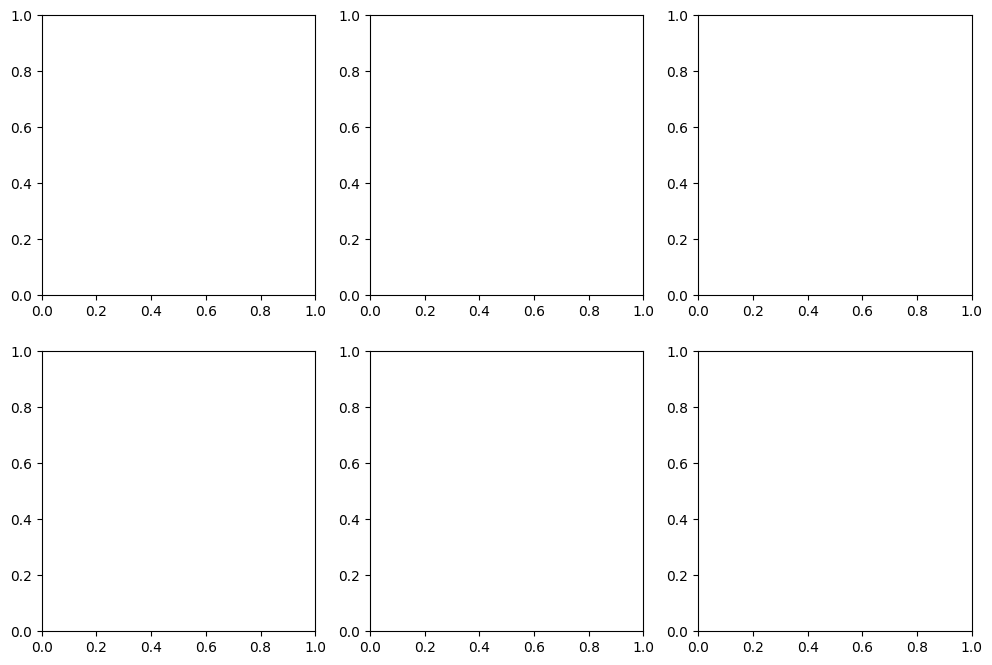

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = "5"

image_files = [
    '0_0.png', '0_1.png', '0_2.png',
    '1_0.png', '1_1.png', '1_2.png'
]

# Create a 2x3 grid for displaying images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through the image files and axes to display each image
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(f"{WORKING_DIR}/expert_outputs/{image}_{image_files[i]}")
    ax.imshow(img)
    ax.set_title(image_files[i])  # Set title for each image (optional)
    ax.axis('off')  # Turn off axis

# Adjust layout
plt.tight_layout()
plt.show()


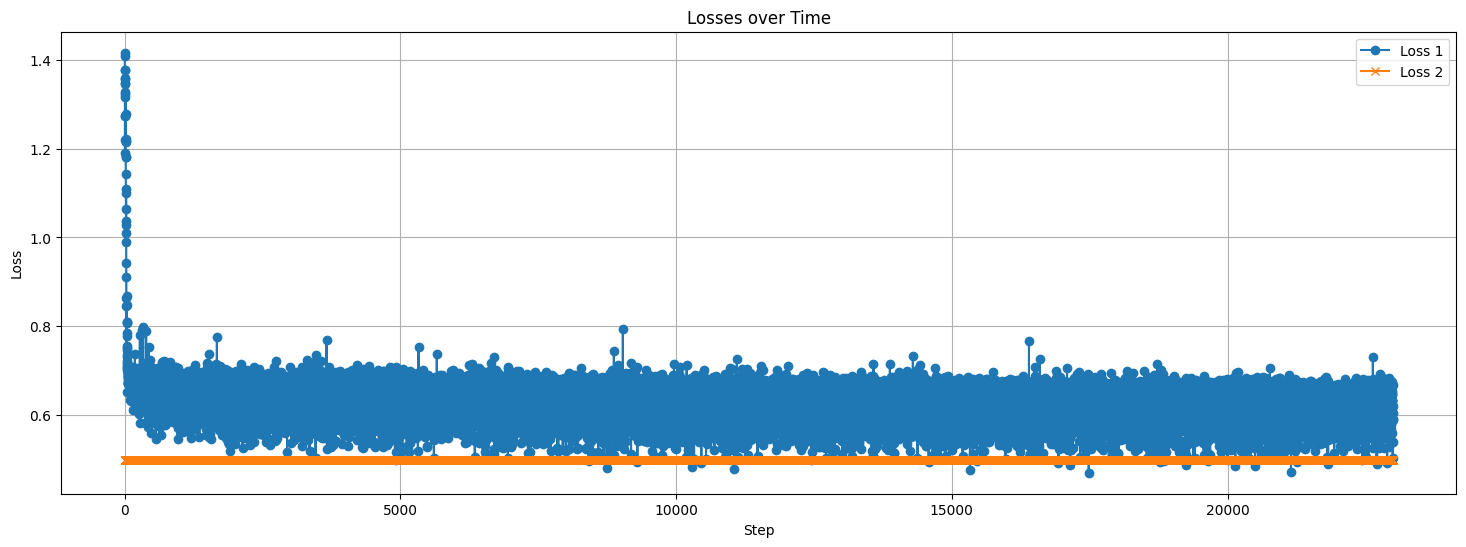

In [13]:
import pickle
import matplotlib.pyplot as plt
import torch

# Path to your pickle file
pickle_file = 'losses'

# Load the pickle file
with open(pickle_file, 'rb') as file:
    loss_data = pickle.load(file)

loss1 = [loss[0].cpu().detach().numpy()
         for epoch_losses in loss_data for loss in epoch_losses]
loss2 = [loss[1].cpu().detach().numpy()
         for epoch_losses in loss_data for loss in epoch_losses]


# Plot the losses
plt.figure(figsize=(18, 6))
plt.plot(loss1, label='Loss 1', marker='o')
plt.plot(loss2, label='Loss 2', marker='x')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Losses over Time')
plt.legend()
plt.grid()
plt.show()

[tensor(1.4082, device='cuda:0', requires_grad=True),
 tensor(0.6388, device='cuda:0', requires_grad=True),
 tensor(0.5634, device='cuda:0', requires_grad=True),
 tensor(0.5611, device='cuda:0', requires_grad=True),
 tensor(0.6042, device='cuda:0', requires_grad=True)]